In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
import random
import os
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from ignite.metrics import Recall, Precision, Accuracy
from sklearn import metrics
import codecs
from efficientnet_pytorch import model as enet
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [2]:
torch.cuda.empty_cache()

### Config

In [3]:
conf_dict = {
    "batch_size": 8,
    "learn_rate": 1e-3,
    "min_learn_rate": 1e-6,
    "weight_decay": 1e-4,
    "epochs": 10,

    "transfer_model_name": "efficientnet-b1",
    "use_backbone": True,

    "input_dir": "../input/seti-breakthrough-listen/",
    "train_dir": "../input/seti-breakthrough-listen/train/",
    "train_csv": "train_labels.csv",
    "test_dir": "../input/seti-breakthrough-listen/test/",
    "test_csv": "sample_submission.csv",
    "efficientnetdir": "../input/efficientnetpytorch/",
    "height": 512,
    "width": 512,

    "model": "schnaufnet_trained",
    "model_to_load": "schnaufnet_trained.pth",

    "origin_height": 273,
    "origin_width": 256,

    "only_use": 1000,
    "behaviours": {
        "all": "all",
        "weighted": "weighted",
    },
    "use_all": True,
    "split_until_ratio": (3 / 4),
    "load_model": False,
}
current_split_behaviour = conf_dict["behaviours"]["weighted"]
new_split_behaviour = conf_dict["behaviours"]["all"]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [4]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

### Custom Dataset

In [5]:
class SETIDataset(Dataset):
	"""Dataset for training data"""
	def __init__(self, df, transform=None, use_cv_preprocessing=False):
		self.df = df
		self.labels = self.df["target"].values
		self.file_names = self.df['file_path'].values
		self.transform = transform
		# self.use_cv_preprocessing = use_cv_preprocessing

	def __len__(self):
		return len(self.df)

		# testing with single batch - for example with 1k epochs
		# return conf_dict["batch_size"]

	def __getitem__(self, idx):
		file_path = self.file_names[idx]
		image = np.load(file_path)
		image = image.astype(np.float32)

		# if self.use_cv_preprocessing:
		# 	cadence = Cadence(file_path)
		# 	cadence.cv()

		# image = np.vstack(image).T

		# if self.transform:
		# 	image = self.transform(image=image)['image']
		# else:
		# 	image = image[np.newaxis,:,:] # add dimension
		# 	image = torch.from_numpy(image).float()

		label = torch.tensor(self.labels[idx]).float()

		# image = image.repeat(3, 1, 1) # TODO: probably just repeating the single channel isnt the best way => probably converting grayscale to rgb is better

		return image, label



In [6]:
class EfficientNetBackbone(nn.Module):
    def __init__(self, out_dim, backbone=None, load_schnaufnet_model=False):
        super(EfficientNetBackbone, self).__init__()
        print("Initializing Efficientnet Backbone")
        model_name = conf_dict["transfer_model_name"]
        self.enet = enet.EfficientNet.from_name(model_name)
        if not load_schnaufnet_model:
            print("Loading pretrained efficientnet model")
            pretrained_model = {
                model_name: conf_dict["efficientnetdir"] + 'efficientnet-b1-dbc7070a.pth'
            }
            self.enet.load_state_dict(torch.load(pretrained_model[model_name]))
        else:
            print("Loading pretrained schnaufnet model")
            model.load_state_dict(torch.load(conf_dict["model_to_load"]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [7]:
def split(train_index, val_index, behaviour="all"):
    train_df, val_df = df_train.iloc[train_index], df_train.iloc[val_index]
    
    dataset_train = SETIDataset(train_df, transform=get_transforms(data="train"))#, use_cv_preprocessing_preprocessing=True)
    dataset_val = SETIDataset(val_df, transform=get_transforms(data="val"))#, use_cv_preprocessing=True) # extra dataset für validation, da validation data nicht transformiert werden darf

    if behaviour == conf_dict["behaviours"]["weighted"]:
        print("Using 50/50 weighted data...")
        labels = np.array(dataset_train.labels)
        class_counts = np.array(
            [len(np.where(labels == t)[0]) for t in np.unique(labels)])
        num_samples = sum(class_counts)
        class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
        weights = [class_weights[labels[i]] for i in range(int(num_samples))]
        sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
        train_dataloader = DataLoader(
            dataset_train, batch_size=conf_dict["batch_size"], sampler=sampler)
    elif behaviour == conf_dict["behaviours"]["all"]:
        print("Using original full data...")
        train_dataloader = DataLoader(dataset_train, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
    val_dataloader = DataLoader(dataset_val, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
    # get_0_1_ratio(train_dataloader, train=True)
    # get_0_1_ratio(val_dataloader, train=True)

    # image, label = next(iter(train_dataloader))
    # print("Shape of image [N, C, H, W]: ", image.shape)
    # print("Shape of label: ", label.shape, label.dtype)

    print(f"Successfully splitted dataset!\n Trainbatches: {len(train_dataloader)}\n Validationbatches: {len(val_dataloader)}")

    return train_dataloader, val_dataloader

def get_0_1_batches_ratio(dataloader):
    print("dataloader length: ", len(dataloader))
    for i, (data, target) in enumerate(dataloader):
        print (f"batch index {i}, 0/1: {len(np.where(target.numpy() == 0)[0])}/{len(np.where(target.numpy() == 1)[0])}")

def get_0_1_ratio(dataloader, train):
    dataloader_0 = 0
    dataloader_1 = 0
    for i, (data, target) in enumerate(dataloader):
        dataloader_0 += len(np.where(target.numpy() == 0)[0])
        dataloader_1 += len(np.where(target.numpy() == 1)[0])
    dataloaderinformation = "train" if train else "val"
    print(f"{dataloaderinformation} dataloader 0/1 ratio: {dataloader_0}, {dataloader_1}")

In [8]:
def train_loop(model, train_dataloader, optimizer, loss_fn, scheduler):
    print("Starting model training...")
    model.train()
    epoch_loss = 0
    epoch_loss_list = []
    num_batches = len(train_dataloader)

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    for (images, labels) in tqdm(train_dataloader, position=0, leave=True, desc='Training'):
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        pred = model(images)
        loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
        epoch_loss_list.append(loss.item())
        epoch_loss += loss.item() # add loss for whole batch
        loss.backward()
        optimizer.step()
        scheduler.step()
        predicted = torch.sigmoid(pred).round() # if precision gets higher => write own function which does not seperate <0.5 and >=0.5 like round currently does
        accuracy.update((predicted, labels))
        precision.update((predicted, labels))
        recall.update((predicted, labels))

    avg_epoch_loss = epoch_loss / num_batches
    print(f"""Training Error: \n 
        Accuracy: {100*accuracy.compute():>2f}%, \n
        Recall: {100*recall.compute():>2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """) # avg loss is summed losses for all batches divided with num batches
    # print(f"Epoch loss list: {epoch_loss_list}")
    with codecs.open('logs/schnaufNet2.0 train.log', 'a') as up:
        up.write(f"""Validation Error: \n
            Accuracy: {100*accuracy.compute():2f}%, \n
            Recall: {100*recall.compute():2f}%, \n
            Precision: {100*precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)
    plt.plot(epoch_loss_list, "ro-")
    plt.title("Loss over epoch")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()

def validation_loop(model, val_dataloader, loss_fn):
    print("Starting model validation...")
    model.eval()

    epoch_loss = 0
    num_batches = len(val_dataloader)
    epoch_labels = []
    epoch_preds = []

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    with torch.no_grad():
        for (images, labels) in tqdm(val_dataloader, position=0, leave=True, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
            epoch_loss += loss.item()
            predicted = torch.sigmoid(pred).round()
            accuracy.update((predicted, labels))
            precision.update((predicted, labels))
            recall.update((predicted, labels))
            
            predicted = torch.sigmoid(pred)
            labels = labels.detach().cpu().numpy().tolist()
            predicted = predicted.detach().cpu().numpy().tolist()
            epoch_labels.extend(labels)
            epoch_preds.extend(predicted)

    avg_epoch_loss = epoch_loss / num_batches
    print(f"""Validation Error: \n
        Accuracy: {100*accuracy.compute():2f}%, \n
        Recall: {100*recall.compute():2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """)
    with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
        up.write(f"""Validation Error: \n
            Accuracy: {100*accuracy.compute():2f}%, \n
            Recall: {100*recall.compute():2f}%, \n
            Precision: {100*precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)
    return epoch_labels, epoch_preds

In [9]:
def get_transforms(data):
    pass
    # if data == 'train':
    #     return A.Compose([
    #         # A.Resize(conf_dict["height"], conf_dict["width"]),
    #         A.VerticalFlip(p=0.5),
    #         A.HorizontalFlip(p=0.5),
    #         ToTensorV2(),
    #     ])
    # elif data == 'val' or data == 'test':
    #     return A.Compose([
    #         # A.Resize(conf_dict["height"], conf_dict["width"]),
    #         ToTensorV2(),
    #     ])

def get_file_path(target, directory):
    return directory + "{}/{}.npy".format(target[0], target)

Initializing Efficientnet Backbone
Loading pretrained efficientnet model
+++ Fold 0 +++
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 10
 Validationbatches: 3
Epoch 1/2
-------------------------------
Starting model training...


Training: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

Training Error: 
 
        Accuracy: 72.500000%, 

        Recall: 82.222222%, 

        Precision: 72.549020%, 

        Avg loss: 0.584757 

    


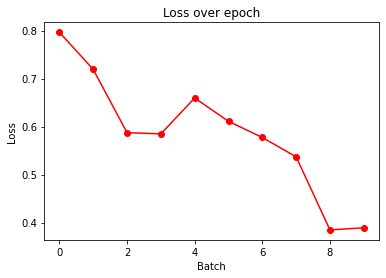

Starting model validation...


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 14.29it/s]


Validation Error: 

        Accuracy: 80.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.542136 

    
Val ROC AUC Score: 0.368421052631579
Epoch 2/2
-------------------------------
!!! Changing train and validation data from weighted behaviour to all behaviour !!!
Using original full data...
Successfully splitted dataset!
 Trainbatches: 10
 Validationbatches: 3
Starting model training...


Training: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

Training Error: 
 
        Accuracy: 62.500000%, 

        Recall: 100.000000%, 

        Precision: 18.918919%, 

        Avg loss: 0.660211 

    


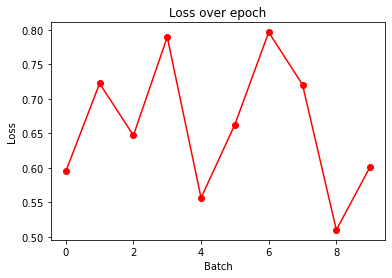

Starting model validation...


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 14.84it/s]


Validation Error: 

        Accuracy: 85.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.481215 

    
Val ROC AUC Score: 0.10526315789473684
Training done! Saving model...
Saved model!
+++ Fold 1 +++
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 10
 Validationbatches: 3
Epoch 1/2
-------------------------------
Starting model training...


Training: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

Training Error: 
 
        Accuracy: 91.250000%, 

        Recall: 85.416667%, 

        Precision: 100.000000%, 

        Avg loss: 0.384679 

    


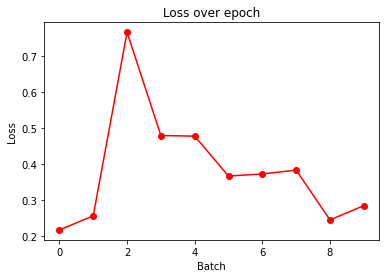

Starting model validation...


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 14.31it/s]


Validation Error: 

        Accuracy: 90.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.295667 

    
Val ROC AUC Score: 0.9473684210526316
Epoch 2/2
-------------------------------
!!! Changing train and validation data from weighted behaviour to all behaviour !!!
Using original full data...
Successfully splitted dataset!
 Trainbatches: 10
 Validationbatches: 3
Starting model training...


Training: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

Training Error: 
 
        Accuracy: 87.500000%, 

        Recall: 100.000000%, 

        Precision: 41.176471%, 

        Avg loss: 0.397510 

    


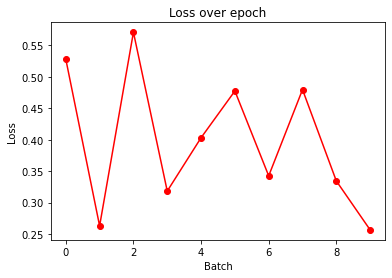

Starting model validation...


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 15.27it/s]


Validation Error: 

        Accuracy: 90.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.280362 

    
Val ROC AUC Score: 0.9473684210526316
Training done! Saving model...
Saved model!
+++ Fold 2 +++
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 10
 Validationbatches: 3
Epoch 1/2
-------------------------------
Starting model training...


Training: 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

Training Error: 
 
        Accuracy: 96.250000%, 

        Recall: 94.736842%, 

        Precision: 97.297297%, 

        Avg loss: 0.220883 

    


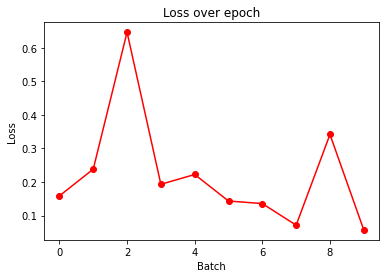

Starting model validation...


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 14.54it/s]


Validation Error: 

        Accuracy: 100.000000%, 

        Recall: 100.000000%, 

        Precision: 100.000000%, 

        Avg loss: 0.158864 

    
Val ROC AUC Score: 1.0
Epoch 2/2
-------------------------------
!!! Changing train and validation data from weighted behaviour to all behaviour !!!
Using original full data...
Successfully splitted dataset!
 Trainbatches: 10
 Validationbatches: 3
Starting model training...


Training: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

Training Error: 
 
        Accuracy: 92.500000%, 

        Recall: 100.000000%, 

        Precision: 50.000000%, 

        Avg loss: 0.237055 

    


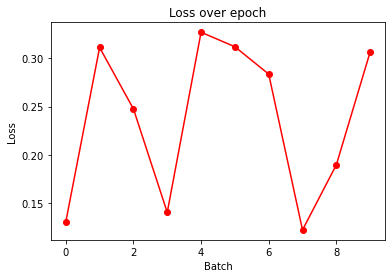

Starting model validation...


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 14.28it/s]


Validation Error: 

        Accuracy: 95.000000%, 

        Recall: 50.000000%, 

        Precision: 100.000000%, 

        Avg loss: 0.270890 

    
Val ROC AUC Score: 0.9166666666666667
Training done! Saving model...
Saved model!
+++ Fold 3 +++
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 10
 Validationbatches: 3
Epoch 1/2
-------------------------------
Starting model training...


Training: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

Training Error: 
 
        Accuracy: 91.250000%, 

        Recall: 83.720930%, 

        Precision: 100.000000%, 

        Avg loss: 0.174295 

    


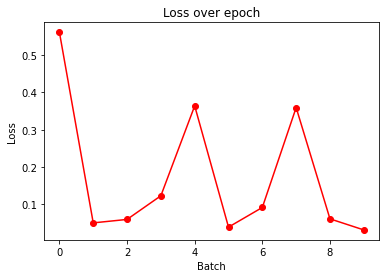

Starting model validation...


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 14.85it/s]


Validation Error: 

        Accuracy: 90.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.219815 

    
Val ROC AUC Score: 0.8611111111111112
Epoch 2/2
-------------------------------
!!! Changing train and validation data from weighted behaviour to all behaviour !!!
Using original full data...
Successfully splitted dataset!
 Trainbatches: 10
 Validationbatches: 3
Starting model training...


Training: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

Training Error: 
 
        Accuracy: 95.000000%, 

        Recall: 100.000000%, 

        Precision: 60.000000%, 

        Avg loss: 0.188848 

    


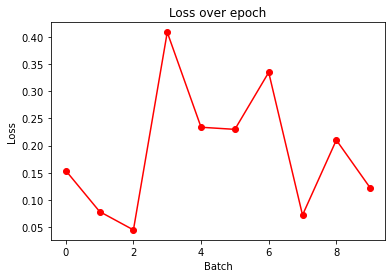

Starting model validation...


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 14.83it/s]


Validation Error: 

        Accuracy: 90.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.397499 

    
Val ROC AUC Score: 0.8611111111111112
Training done! Saving model...
Saved model!
+++ Fold 4 +++
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 10
 Validationbatches: 3
Epoch 1/2
-------------------------------
Starting model training...


Training: 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

Training Error: 
 
        Accuracy: 96.250000%, 

        Recall: 93.023256%, 

        Precision: 100.000000%, 

        Avg loss: 0.124058 

    


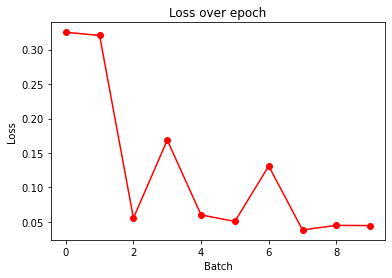

Starting model validation...


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 15.07it/s]


Validation Error: 

        Accuracy: 90.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.377913 

    
Val ROC AUC Score: 0.8888888888888888
Epoch 2/2
-------------------------------
!!! Changing train and validation data from weighted behaviour to all behaviour !!!
Using original full data...
Successfully splitted dataset!
 Trainbatches: 10
 Validationbatches: 3
Starting model training...


Training: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

Training Error: 
 
        Accuracy: 92.500000%, 

        Recall: 100.000000%, 

        Precision: 50.000000%, 

        Avg loss: 0.177659 

    


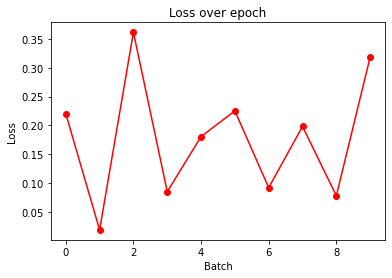

Starting model validation...


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 15.04it/s]


Validation Error: 

        Accuracy: 90.000000%, 

        Recall: 0.000000%, 

        Precision: 0.000000%, 

        Avg loss: 0.216007 

    
Val ROC AUC Score: 0.9722222222222222
Training done! Saving model...
Saved model!
Best model in fold 4, epoch 1 with roc_auc of 0.9722222222222222


In [10]:
model = EfficientNetBackbone(out_dim=1, load_schnaufnet_model=conf_dict["load_model"])
model.to(device)

df_train = pd.read_csv(conf_dict["input_dir"] + conf_dict["train_csv"])
if not conf_dict["use_all"]:
    df_train = df_train[:conf_dict["only_use"]]
df_train["file_path"] = df_train["id"].apply(get_file_path, directory=conf_dict["train_dir"])

loss_fn = nn.BCEWithLogitsLoss() # nn.BCELoss() => needs sigmoid as activation function
optimizer = torch.optim.Adam(model.parameters(), lr=conf_dict["learn_rate"], weight_decay=conf_dict["weight_decay"]) # torch.optim.SGD(model.parameters(), lr=conf_dict["learn_rate"]) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=conf_dict["epochs"], eta_min=conf_dict["min_learn_rate"], last_epoch=-1
)
num_epochs = conf_dict["epochs"]
skf = StratifiedKFold(n_splits=5)

with codecs.open('logs/schnaufNet2.0 train.log', 'a') as up:
    up.write("------------------ new training ------------------")
with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
    up.write("------------------ new validation ------------------")

for fold, (train_index, val_index) in enumerate(skf.split(df_train, df_train["target"])):
    print(f"+++ Fold {fold} +++")
    train_dataloader, val_dataloader = split(train_index, val_index, behaviour=current_split_behaviour)
    best_roc_auc = 0
    best_roc_auc_fold = 0
    best_roc_auc_fold_epoch = 0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}\n-------------------------------")
        if epoch == math.floor(num_epochs * conf_dict["split_until_ratio"]):
            print(f"!!! Changing train and validation data from {current_split_behaviour} behaviour to {new_split_behaviour} behaviour !!!")
            train_dataloader, val_dataloader = split(train_index, val_index, behaviour=new_split_behaviour)
        train_loop(model, train_dataloader, optimizer, loss_fn, scheduler)
        val_labels, val_predictions = validation_loop(model, val_dataloader, loss_fn)
        roc_auc = metrics.roc_auc_score(val_labels, val_predictions)
        print(f"Val ROC AUC Score: {roc_auc}")
        with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
            up.write(f"""
                Epoch={epoch}, Valid ROC AUC={roc_auc}\n
            """)
        if roc_auc > best_roc_auc:
            torch.save(model.state_dict(), "best_roc_auc_" + conf_dict["model"] + "-" + str(fold) + "-" + str(epoch) + ".pth")
            best_roc_auc = roc_auc
            best_roc_auc_fold = fold
            best_roc_auc_epoch = epoch
    print("Training done!")
    # torch.save(model.state_dict(), "version_" + conf_dict["model"] + "-" + str(fold) + ".pth")
print(f"Best model in fold {best_roc_auc_fold}, epoch {best_roc_auc_epoch} with roc_auc of {best_roc_auc}")
